Fetched 10 headlines for topic 'technology'.

Summary:
  variant  impressions  clicks       ctr
0       A         2505     260  0.103792
1       B         2495     305  0.122244

Two-proportion z-test:
Z = -2.061, p-value = 0.0393


/tmp/ipython-input-531630866.py:78: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  clicks_A = int(summary.loc[summary.variant=="A","clicks"])
/tmp/ipython-input-531630866.py:79: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n_A = int(summary.loc[summary.variant=="A","impressions"])
/tmp/ipython-input-531630866.py:80: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  clicks_B = int(summary.loc[summary.variant=="B","clicks"])
/tmp/ipython-input-531630866.py:81: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n_B = int(summary.loc[summary.variant=="B","impressions"])


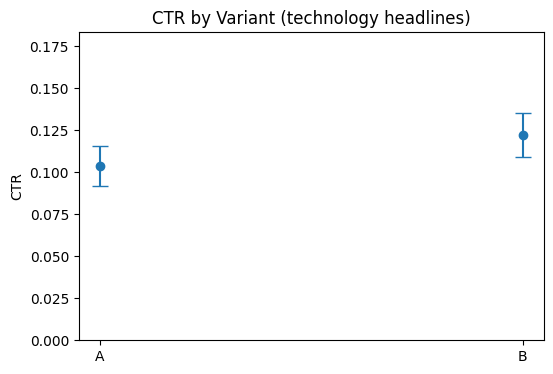

In [3]:
# --- A/B Testing with News API (Colab Ready) ---

!pip install requests scipy matplotlib pandas

import requests
import random
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm

# ========== CONFIG ==========
API_KEY = "36a308dbd3e242de83224b82ec4b1b7a"  # <-- Paste your News API key here
QUERY = "technology"           # Topic for news headlines
PAGE_SIZE = 10                  # Number of articles to fetch
SIM_USERS = 5000                # Number of simulated users
CTR_A = 0.10                    # True CTR for A (10%)
CTR_B = 0.12                    # True CTR for B (12%)
# ============================

# 1) Fetch headlines from News API
url = f"https://newsapi.org/v2/everything?q={QUERY}&pageSize={PAGE_SIZE}&apiKey={API_KEY}"
response = requests.get(url)
data = response.json()

if "articles" not in data:
    raise ValueError(f"News API Error: {data}")

articles = [a["title"] for a in data["articles"] if a.get("title")]
print(f"Fetched {len(articles)} headlines for topic '{QUERY}'.")

# 2) Create variants
variants = []
for title in articles:
    # Variant A: Original headline
    variants.append({"variant": "A", "headline": title})
    # Variant B: Slightly rewritten (just add a suffix for demo)
    variants.append({"variant": "B", "headline": title + " - Breaking Update"})

# 3) Simulate impressions & clicks
records = []
for _ in range(SIM_USERS):
    # Pick a random article variant
    chosen = random.choice(variants)
    clicked = 0
    if chosen["variant"] == "A":
        clicked = np.random.binomial(1, CTR_A)
    else:
        clicked = np.random.binomial(1, CTR_B)
    records.append({
        "variant": chosen["variant"],
        "headline": chosen["headline"],
        "clicked": clicked
    })

df = pd.DataFrame(records)

# 4) Aggregate results
summary = df.groupby("variant").agg(
    impressions=("clicked", "count"),
    clicks=("clicked", "sum")
).reset_index()
summary["ctr"] = summary["clicks"] / summary["impressions"]
print("\nSummary:")
print(summary)

# 5) Two-proportion z-test
def two_proportion_z_test(clicks_A, n_A, clicks_B, n_B):
    p_pool = (clicks_A + clicks_B) / (n_A + n_B)
    se = math.sqrt(p_pool * (1 - p_pool) * (1/n_A + 1/n_B))
    p1 = clicks_A / n_A
    p2 = clicks_B / n_B
    z = (p1 - p2) / se
    p_value = 2 * (1 - norm.cdf(abs(z)))  # two-sided
    return z, p_value

clicks_A = int(summary.loc[summary.variant=="A","clicks"])
n_A = int(summary.loc[summary.variant=="A","impressions"])
clicks_B = int(summary.loc[summary.variant=="B","clicks"])
n_B = int(summary.loc[summary.variant=="B","impressions"])

z, p_value = two_proportion_z_test(clicks_A, n_A, clicks_B, n_B)
print(f"\nTwo-proportion z-test:\nZ = {z:.3f}, p-value = {p_value:.4f}")

# 6) Plot CTRs with CI
summary["ctr_se"] = np.sqrt(summary["ctr"] * (1 - summary["ctr"]) / summary["impressions"])
plt.figure(figsize=(6,4))
plt.errorbar(summary["variant"], summary["ctr"], yerr=1.96*summary["ctr_se"], fmt='o', capsize=6)
plt.ylabel("CTR")
plt.title(f"CTR by Variant ({QUERY} headlines)")
plt.ylim(0, max(summary ["ctr"]*1.5))
plt.show()